In [139]:
import dask.array as da
from dask import delayed
from dask.array.image import imread

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [5]:
import scipy.linalg as la

In [ ]:
# path to bubbles
path = '/media/val/7AA2E24AA2E20A89/microbubbles/Test1/'

In [ ]:
video = imread(path+'*.tif')

In [ ]:
(T, m, n) = video.shape

In [ ]:
from daskDMD import dmd_dask, dmd_evolve_dask

In [ ]:
data = video.reshape((T,m*n))
data = data.T
data.rechunk((1000,T))

In [ ]:
mu, Psi, s = dmd_dask(data.T,5)

In [173]:
def eig_dask(A,nofIt = None):
    A_new = A
    if nofIt is None:
        nofIt = A.shape[0]
    V = da.eye(A.shape[0],100)
    for i in range(nofIt):
        Q,R = da.linalg.qr(A_new)
        A_new = da.dot(R,Q)
        V = da.dot(V,Q)
    return(da.diag(A_new),V)
    

In [155]:
def eig(A):
    A_new = np.copy(A)
    nofIt = A.shape[0]
    V = np.eye(A.shape[0])
    for i in range(nofIt):
        Q,R = la.qr(A_new,mode = 'full')
        A_new = np.dot(R,Q)
        V = np.dot(V,Q)
    return(np.diag(A_new),V)
    

In [156]:
A = np.random.random((100,100))
A_sym = np.dot(A.T,A)
Q,R = la.qr(A)

In [157]:
A_new = np.dot(Q,R)

2.3314683517128287e-15

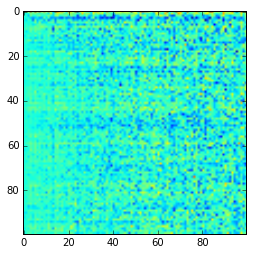

In [158]:
plt.imshow(A_new - A)
np.max(np.abs(A_new-A))

In [165]:
L,V = eig(A_sym)

In [174]:
A_da = da.from_array(A_sym, (100,100))
L,V = eig_dask(A_da)

In [175]:
check_eig(A_da,V,L)

0.56142783108942185

In [161]:
def check_eig(A,V,L):
    error = la.norm(np.dot(A,V) - np.dot(V,np.diag(L)))
    return(error)
    

In [153]:
check_eig(A_sym,V,L)

0.63567615135471789

In [117]:
l,v = la.eig(A_sym)

In [118]:
check_eig(A_sym,v,l)

3.742595282572502e-12

In [119]:
np.real(l) - L

array([  3.18323146e-12,   2.48689958e-13,   3.36689499e-05,
        -3.36689494e-05,   3.78809358e-05,  -3.78809358e-05,
         5.17547206e-06,   3.48615853e-05,   9.43007421e-02,
        -3.79326719e-01,   2.84985985e-01,   8.06015922e-04,
        -8.06049242e-04,  -1.10905347e-08,   3.84619980e-09,
         4.27068568e-04,   2.40251915e-02,  -2.44522640e-02,
         5.72299786e-06,   1.11815084e-05,  -4.00249603e-06,
         1.04727052e-04,  -1.16818743e-04,   3.14360331e-03,
        -3.14441330e-03,   3.93178879e-03,  -3.93135544e-03,
         3.23253567e-04,  -3.23500061e-04,  -1.51996474e-07,
        -3.51759173e-08,   1.03184024e-05,   2.12464718e-03,
        -2.13496558e-03,   2.13276994e-07,  -2.09695088e-07,
         1.60599062e-06,  -1.22157475e-06,   2.10420313e-04,
        -2.10805888e-04,  -2.43254483e-09,   4.11423873e-09,
         4.88939328e-03,  -4.88939739e-03,   1.78772552e-11,
         2.06782247e-06,   1.22739848e-05,   1.00190416e-05,
        -2.52812403e-01,

In [120]:
np.real(v) - V

array([[ -6.66133815e-16,   3.01818671e-09,   3.42470232e-01, ...,
         -1.75567149e-01,   1.24322443e-01,   1.56994566e-01],
       [ -2.22044605e-16,   1.18346055e-09,   1.35027855e-01, ...,
         -1.42871454e-02,   7.01484852e-02,  -1.79341464e-01],
       [ -2.77555756e-17,  -1.95953434e-09,  -2.26195664e-01, ...,
          1.08510391e-01,  -1.03650197e-01,  -3.04144032e-01],
       ..., 
       [ -1.38777878e-16,   5.47010611e-10,   6.34673830e-02, ...,
          2.58066789e-02,   3.67599205e-01,   2.64339114e-01],
       [ -4.16333634e-17,  -3.68267304e-09,  -4.25970059e-01, ...,
         -9.38603343e-02,  -5.84488714e-02,   5.09589874e-02],
       [  1.66533454e-16,  -1.93729575e-09,  -2.25205765e-01, ...,
          1.21719988e-01,   3.21418371e-01,  -2.10373751e-01]])

In [121]:

def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = la.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

In [122]:
V_new = nullspace(A_sym - L[0]*np.eye(100),atol=1e-11)

In [123]:
B = np.array([[52,   30 ,  49,   28],
[30,   50,    8,   44],
[49,    8,   46,  16],
[28,   44,   16, 22]])

In [124]:
B_L,B_V = eig(B)

In [133]:
B_l,B_v = la.eig(B)

In [132]:
check_eig(B,B_V,B_L)

1.0166861286179287e-13

In [134]:
check_eig(B,B_v,B_l)

6.6407817600925434e-14

In [131]:
B_V = eigenvectors(B,B_L)
check_eig(B,B_V,B_L)
B_V

(4, 1)
(4, 1)
(4, 1)
(4, 1)


array([[ 0.60945955,  0.29991942, -0.09987744, -0.72707077],
       [ 0.48785283, -0.65199675,  0.57724915,  0.06068999],
       [ 0.4665778 ,  0.60196233,  0.22156327,  0.60897966],
       [ 0.41576896, -0.35012847, -0.77956246,  0.31117293]])

In [127]:
V_new-v[:,0]

array([[  4.02455846e-16,   8.53201691e-04,   5.00359519e-03, ...,
          4.05232170e-03,   9.21069686e-03,   1.72203149e-02],
       [ -8.53201691e-04,   4.71844785e-16,   4.15039350e-03, ...,
          3.19912001e-03,   8.35749517e-03,   1.63671132e-02],
       [ -5.00359519e-03,  -4.15039350e-03,  -2.77555756e-17, ...,
         -9.51273492e-04,   4.20710167e-03,   1.22167197e-02],
       ..., 
       [ -4.05232170e-03,  -3.19912001e-03,   9.51273492e-04, ...,
         -1.38777878e-17,   5.15837516e-03,   1.31679932e-02],
       [ -9.21069686e-03,  -8.35749517e-03,  -4.20710167e-03, ...,
         -5.15837516e-03,   1.38777878e-17,   8.00961806e-03],
       [ -1.72203149e-02,  -1.63671132e-02,  -1.22167197e-02, ...,
         -1.31679932e-02,  -8.00961806e-03,  -1.38777878e-17]])

In [128]:
def eigenvectors(A,L):
    atol = 1e-10
    V = []
    I = np.eye(A.shape[0])
    for l in L:
        v = nullspace(A - l*I,atol = atol)
        print(v.shape)
        V.append(v)
    return(np.hstack(tuple(V)))
        
    

In [129]:
V_new = eigenvectors(A_sym, L)

(100, 1)
(100, 1)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 1)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 1)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 1)
(100, 1)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 0)
(100, 1)
(100, 0)
(100, 0)
(100, 0)
(100, 1)
(100, 1)
(100, 1)
(100, 0)
(100, 0)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 0)
(100, 0)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)


In [130]:
check_eig(A_sym,V_new,L)

ValueError: shapes (100,28) and (100,100) not aligned: 28 (dim 1) != 100 (dim 0)

In [62]:
V_new.shape

(100, 100)

In [96]:
np.eye(3)

array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])